## SETUP

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import load_model
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import pandas as pd

import imageio
from tensorflow_docs.vis import embed

## PARAMETERS

In [26]:
image_size = 256
generator_input = 16
batch_size = 8

## IMPORT

In [27]:
dataset = keras.preprocessing.image_dataset_from_directory(
   "images_proc", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 9132 files belonging to 1 classes.


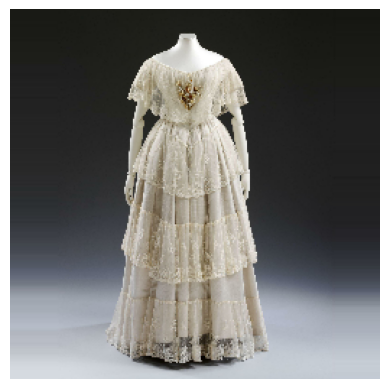

In [31]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [36]:
discriminator = keras.Sequential(
    [   
        # use maxpool instead of conv2d at the first two downsize

        keras.Input(shape=(image_size, image_size, 3)),
        layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"),
        # layers.Conv2D(64, kernel_size=4, strides=1, padding="same"),      
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same"),        
        # layers.Conv2D(128, kernel_size=4, strides=1, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_16 (MaxPoolin  (None, 128, 128, 3)      0         
 g2D)                                                            
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 128, 128, 3)       0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 3)        0         
 g2D)                                                            
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 32, 128)     

## GENERATOR

In [43]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        
        # addon to match VGG
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        # end of addon

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32768)             4227072   
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 64, 64, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 64, 64, 128)       0 

## GAN

In [44]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [45]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting 1/generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [46]:
learning_rate = 0.0001

In [47]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [58]:
epochs = 19  # In practice, use ~100 epochs

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/19
  47/1142 [>.............................] - ETA: 4:18 - d_loss: 0.5552 - g_loss: 1.0419

### plot and save

In [ ]:
# # uncomment to initiate a dataframe to hold dloss and gloss
# dg_df = pd.DataFrame(columns=['d_loss','g_loss'])

In [ ]:
d_loss = gan.history.history['d_loss']
g_loss = gan.history.history['g_loss']
epch = range(1,len(d_loss)+1)

In [ ]:
dg_list = list(zip(d_loss,g_loss))
dg_df_new = pd.DataFrame(dg_list,columns=['d_loss','g_loss'])
dg_df = pd.concat([dg_df,dg_df_new],axis=0)

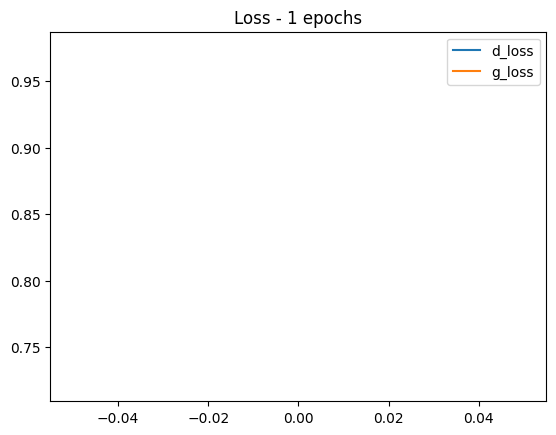

In [ ]:
dg_df.reset_index(drop=True).plot()
plt.title(f"Loss - {epochs} epochs")
plt.legend();

In [23]:
dg_df.to_csv('BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting 1/dgloss.csv',index=False)

In [24]:
gan.save_weights(filepath='BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting 1/GAN_maxpool_9000_1_1ep.ckpt')

## generate


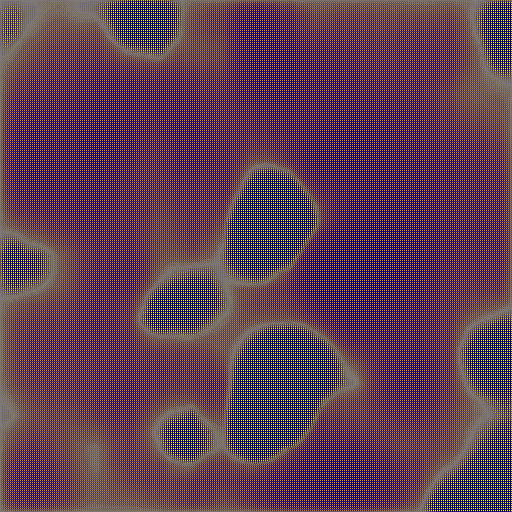

In [25]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 1  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))
noise_and_labels = tf.concat([interpolation_noise], 1)
fake = trained_gen.predict(noise_and_labels)

counter = 1
file_dir = 'BasicGAN_gen/9000img/6.1.2 basic gan maxpool/setting 1/'
file_name = f"result {counter}.gif"
filepath = file_dir + file_name

fake *= 255.0
converted_images = fake.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (512, 512)).numpy().astype(np.uint8)
imageio.mimsave(filepath, converted_images, fps=0.5)
embed.embed_file(filepath)